In [2]:
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using MPSKit
using TensorKit
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using Combinatorics
using LaTeXStrings
using FileIO
using JLD2
Makie.inline!(true)
include("julia_functions.jl")


Trivertex_classical_ising_partition_function (generic function with 2 methods)

Example: 
MPS with physical indices 2,4,2,2,2,4,2,2

In [3]:
function compress_Tenet_MPS(TenetMPS, physical_order, chi_max, printing = false)

    """
    Function which takes in a TenetMPS, a order of the physical indices,
    and a max allowable chi_max. Compresses the MPS using a conversion to MPSKit
    and DMRG compression. After compression reconverts to TenetMPS and returns
    the compressed MPS.
    """

    Tens = Tenet.tensors(TenetMPS)
    additional_fake_indices_of_size1 = [Symbol("fake1"), Symbol("fake2")]
    t_compat = []

    """
    Make the MPS Network compatible with the FiniteMPS from within MPSKit.jl
    """

    left_index = physical_order[1]
    i = 1
    for t in Tens
        if length(inds(t)) == 2
            new_t = Tenet.Tensor(reshape(t.data, (size(t.data)[1], size(t.data)[2], 1)), (inds(t)..., additional_fake_indices_of_size1[i]))
            i += 1
            push!(t_compat, new_t)
            continue
        end
        push!(t_compat, t)
    end
    
    TN_compat = Tenet.TensorNetwork(t_compat)


    global ids 

    T_ordered = []
    inds_connection = []

    for i in 1:length(Tenet.tensors(TN_compat))
        if i == 1
            for t in Tenet.tensors(TN_compat)
                ids = inds(t)
                if !isempty(intersect(inds(t), [left_index]))
                    push!(T_ordered, t)
                    break
                end
            end
        end
        for t in Tenet.tensors(TN_compat)
            if t ∉ T_ordered
                if !isempty(intersect(inds(t), ids))
                    push!(inds_connection, intersect(inds(t), ids)[1])

                    push!(T_ordered, t)
                    ids = inds(t)
                end
            end
        end
    end
    println(inds_connection)
    pushfirst!(inds_connection, additional_fake_indices_of_size1[1])
    push!(inds_connection, additional_fake_indices_of_size1[2])
    inds_connection = [id for id in inds_connection]
    first = [inds_connection[1], physical_order[1], inds_connection[2]]
    last = [inds_connection[end-1], physical_order[end], inds_connection[end]]

    permutation_list = [[inds_connection[i], physical_order[i], inds_connection[i+1]] for i in 2:length(physical_order)-1]
    pushfirst!(permutation_list, first)
    push!(permutation_list, last)


    extracted_maps = []
    approximate_extracted_maps = []
    approximate_sizes_list = []

    """
    Extract the TensorKit Maps
    """

    for (i, t) in enumerate(T_ordered)
        t = permutedims(t, permutation_list[i])
        push!(extracted_maps, TensorMap(t.data, ℂ^(size(t, inds(t)[1])) ⊗ ℂ^(size(t, inds(t)[2])), ℂ^(size(t, inds(t)[3]))))

        # Always keep the correct physical size
        # Keep the bond dimension to the chi_max value or smaller
        # take min(chi_max, needed dim) in the virtual connecting spaces
        # edge cases:
        # if i == 1
        #     push!(approximate_extracted_maps, TensorMap(rand(ComplexF64, size(t, inds(t)[1]), 
        #                                                             (size(t, inds(t)[2])), 
        #                                                             minimum([chi_max, size(t, inds(t)[3])])),
        #                                                             ℂ^minimum([chi_max, size(t, inds(t)[1])]) ⊗ ℂ^(size(t, inds(t)[2])),
        #                                                              ℂ^minimum([chi_max, size(t, inds(t)[3])])))
        #     push!(approximate_sizes_list, (size(t, inds(t)[1])), (size(t, inds(t)[2])), minimum([chi_max, size(t, inds(t)[3])]))
        #     continue
        # end
        # if i == length(T_ordered)
        #     push!(approximate_extracted_maps, TensorMap(rand(ComplexF64, minimum([chi_max, size(t, inds(t)[1])]), 
        #                                                             (size(t, inds(t)[2])), 
        #                                                             size(t, inds(t)[3])),
        #                                                             ℂ^minimum([chi_max, size(t, inds(t)[1])]) ⊗ ℂ^(size(t, inds(t)[2])),
        #                                                              ℂ^size(t, inds(t)[3])))
        #     push!(approximate_sizes_list, (minimum([chi_max, size(t, inds(t)[1])]), (size(t, inds(t)[2])), size(t, inds(t)[3])))
        #     continue
        # end
        # bulk cases:
        push!(approximate_extracted_maps, TensorMap(rand(ComplexF64, minimum([chi_max, size(t, inds(t)[1])]), 
                                                                    (size(t, inds(t)[2])), 
                                                                    minimum([chi_max, size(t, inds(t)[3])])),
                                                                    ℂ^minimum([chi_max, size(t, inds(t)[1])]) ⊗ ℂ^(size(t, inds(t)[2])),
                                                                     ℂ^minimum([chi_max, size(t, inds(t)[3])])))
        push!(approximate_sizes_list, (minimum([chi_max, size(t, inds(t)[1])]), (size(t, inds(t)[2])), minimum([chi_max, size(t, inds(t)[3])])))
    end

    extracted_maps = [map for map in extracted_maps]
    approximate_extracted_maps = [map for map in approximate_extracted_maps]
    
    mps_exact = FiniteMPS(extracted_maps)
    drawing = entanglementplot(mps_exact, site=Int(length(mps_exact)/2))
    entanglement = entanglement_spectrum(mps_exact, Int(length(mps_exact)/2))
    println(entanglement)

    
    display(drawing)


    mps_approximate = FiniteMPS(approximate_extracted_maps)
    
    if printing == true 
        println("Exact MPS = \n" , mps_exact)
        println("Approximate MPS = \n" , mps_approximate)
    end

    """
    Run the compression algorithm 
    """

    # Create a DMRG algorithm instance
    alg = DMRG(;  # Choose DMRG (1-site) for this example
            maxiter = 40,  # Maximum number of iterations
            verbose = false,   # Verbosity level (0: silent, 1: basic, 2: detailed)
            tol = 1e-16
            )
    
    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(mps_exact)), physicalspace(mps_exact, i))) for i in 1:length(mps_exact)]) # corresponding identity operator as an MPO
    mps_new, = approximate(mps_approximate, (I_MPO, mps_exact), alg)



    println("error =", abs(1-dot(mps_new, mps_exact)^2/(dot(mps_new, mps_new)*dot(mps_exact, mps_exact))))
    """
    Reconvert to Tenet.TensorNetwork compatible format
    """

    new_tenet_tensors = []
    for i in 1:length(mps_new)
        if i == length(mps_new)
            shaped_data = reshape(mps_new.AC[i].data, (approximate_sizes_list[i]))
            new_t = Tenet.Tensor(shaped_data, permutation_list[i])
            push!(new_tenet_tensors, new_t)
            break
        end

        shaped_data = reshape(mps_new.AL[i].data, (approximate_sizes_list[i]))
        new_t = Tenet.Tensor(shaped_data, permutation_list[i])
        push!(new_tenet_tensors, new_t)
    end

    TenetMPS = Tenet.TensorNetwork(new_tenet_tensors)

    for fake_index in additional_fake_indices_of_size1
        #println("used fake = ", fake_index)
        t_old = Tenet.select(TenetMPS, fake_index)[1]
        # case where it is an edge tensor
        if length(inds(t_old)) == 2
            id_keep = setdiff(inds(t_old), [fake_index])[1]
            t_new = Tenet.Tensor(reshape(t_old.data, size(t_old, id_keep)), [id_keep])
            pop!(TenetMPS, t_old)
            push!(TenetMPS, t_new)
        end
        # case where it is a bulk tensor
        if length(inds(t_old)) == 3
            id_keep = setdiff(inds(t_old), [fake_index])
            t_new = Tenet.Tensor(reshape(t_old.data, (size(t_old, id_keep[1]), size(t_old, id_keep[2]))), (id_keep))
            pop!(TenetMPS, t_old)
            push!(TenetMPS, t_new)
        end
    end

    inds_new_connection = [Symbol("f$i") for i in 1:8]
    for i in 2:length(inds_new_connection)
        replace!(TenetMPS, inds_connection[i] => inds_new_connection[i])
    end




    return TenetMPS

end

compress_Tenet_MPS (generic function with 2 methods)

6×4×2×2×4×4×2×6 Tenet.Tensor{ComplexF64, 8, Array{ComplexF64, 8}}:
[:, :, 1, 1, 1, 1, 1, 1] =
 0.595134+0.684258im   0.220775+0.152755im   …   0.320515+0.0129225im
 0.372437+0.83301im    0.826047+0.700863im       0.520407+0.979167im
 0.558588+0.619376im   0.786287+0.216963im       0.682492+0.817625im
 0.244385+0.189108im    0.51867+0.0488026im     0.0970531+0.280588im
 0.796196+0.895554im   0.998313+0.311135im       0.551482+0.725556im
 0.721236+0.0901764im  0.249114+0.85755im    …   0.570907+0.801423im

[:, :, 2, 1, 1, 1, 1, 1] =
  0.125704+0.671986im  0.545267+0.491683im  …  0.237307+0.851456im
  0.806787+0.240367im  0.530691+0.170057im     0.163879+0.893149im
  0.886297+0.44101im   0.134853+0.279132im     0.312096+0.148504im
  0.091278+0.13527im   0.350493+0.526769im     0.689796+0.562225im
 0.0204322+0.583135im  0.723956+0.417334im     0.286653+0.356146im
  0.572555+0.121454im  0.775843+0.10822im   …  0.299336+0.361726im

[:, :, 1, 2, 1, 1, 1, 1] =
 0.366749+0.57348im   0.132049+0.

6×4×2×2×4×4×2×6 Tenet.Tensor{ComplexF64, 8, Array{ComplexF64, 8}}:
[:, :, 1, 1, 1, 1, 1, 1] =
 0.595134-0.684258im   0.220775-0.152755im   …   0.320515-0.0129225im
 0.372437-0.83301im    0.826047-0.700863im       0.520407-0.979167im
 0.558588-0.619376im   0.786287-0.216963im       0.682492-0.817625im
 0.244385-0.189108im    0.51867-0.0488026im     0.0970531-0.280588im
 0.796196-0.895554im   0.998313-0.311135im       0.551482-0.725556im
 0.721236-0.0901764im  0.249114-0.85755im    …   0.570907-0.801423im

[:, :, 2, 1, 1, 1, 1, 1] =
  0.125704-0.671986im  0.545267-0.491683im  …  0.237307-0.851456im
  0.806787-0.240367im  0.530691-0.170057im     0.163879-0.893149im
  0.886297-0.44101im   0.134853-0.279132im     0.312096-0.148504im
  0.091278-0.13527im   0.350493-0.526769im     0.689796-0.562225im
 0.0204322-0.583135im  0.723956-0.417334im     0.286653-0.356146im
  0.572555-0.121454im  0.775843-0.10822im   …  0.299336-0.361726im

[:, :, 1, 2, 1, 1, 1, 1] =
 0.366749-0.57348im   0.132049-0.

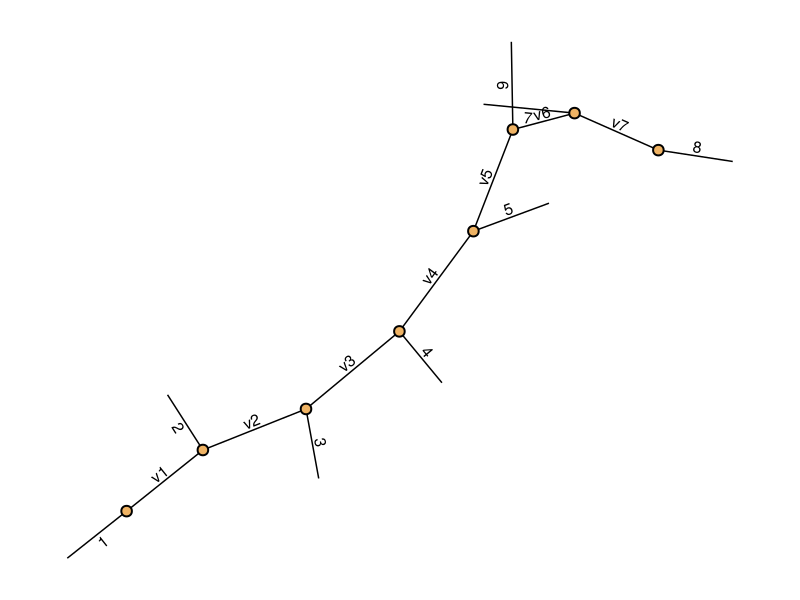

In [7]:
data = rand(ComplexF64, 6,4,2,2,4,4,2,6)
indices = [Symbol(i) for i in 1:8]
virtual = [Symbol("v$i") for i in 1:8]
exact = Tenet.Tensor(data, indices)


global prop_id
T_QR1 = []
R = deepcopy(exact)
for (i, index) in enumerate(indices)
    if i == length(indices)
        push!(T_QR1, R)
        break
    end
    if i == 1
        Q, R = LinearAlgebra.qr(exact, left_inds=[index], virtualind=virtual[i])
        push!(T_QR1, Q)
        global prop_id = setdiff(inds(Q), [index])[1]
    end
    if i > 1
        Q, R = LinearAlgebra.qr(R, left_inds=[index, prop_id], virtualind=virtual[i])
        push!(T_QR1, Q)
        prop_id = setdiff(inds(Q), [index, prop_id])[1]
    end
end

mps_net_full = Tenet.TensorNetwork(T_QR1)
Makie.plot(mps_net_full, labels=true)

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

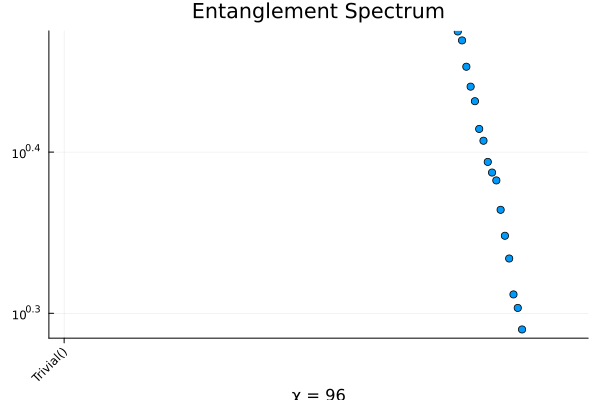

┌ Warning: dmrg failed to converge 1.6433604557845948e-15>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


error =3.175285323921845e-15
 ---------------- Local fidelity analysis ----------------- 
Error = |1- |< loop | mps >|^2 /(|< loop | loop >||< mps | mps >|)|  = 0.0
Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.731396250485250

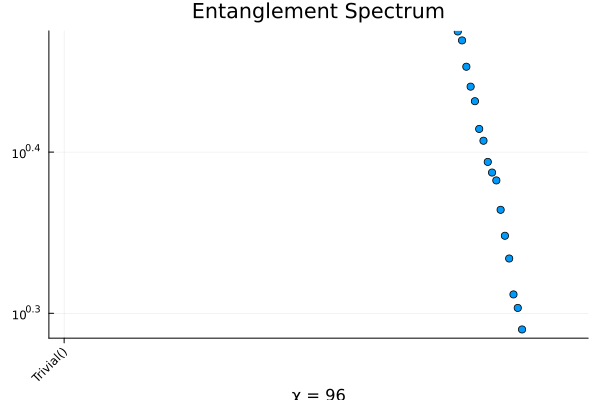

┌ Warning: dmrg failed to converge 0.00019840995161534038>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


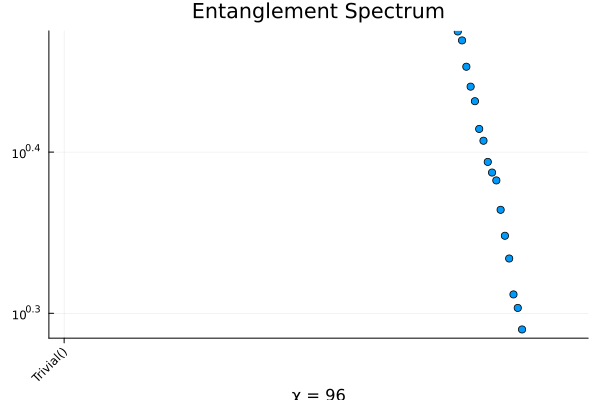

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

┌ Warning: dmrg failed to converge 5.797940787162313e-5>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


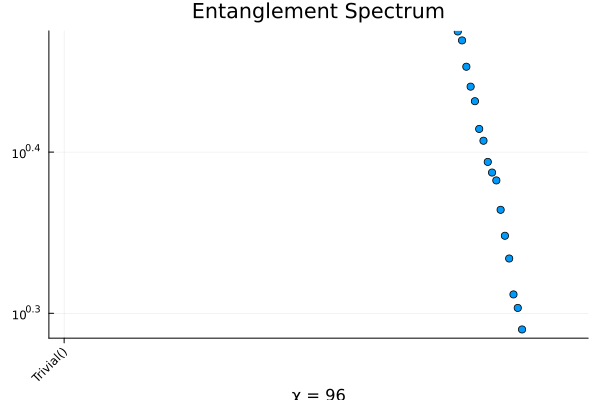

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

┌ Warning: dmrg failed to converge 7.730369647362027e-5>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


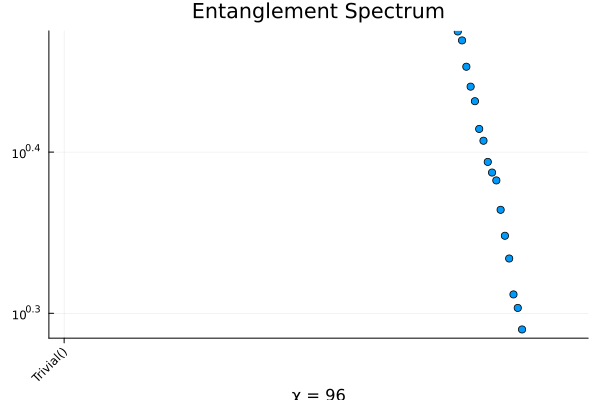

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

┌ Warning: dmrg failed to converge 0.00029649612265391354>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


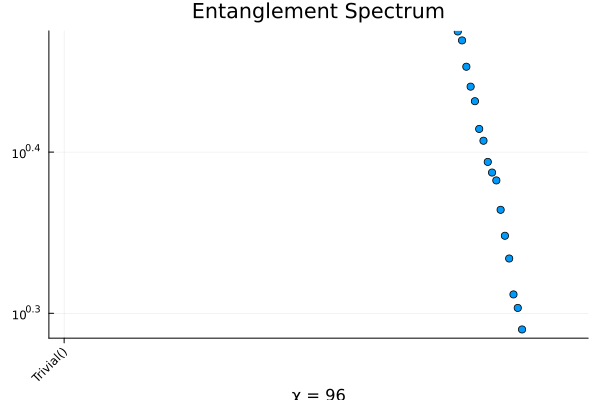

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

┌ Warning: dmrg failed to converge 0.0003208908480200289>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


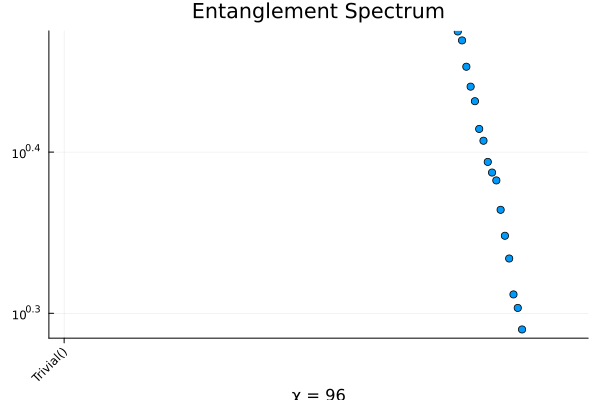

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

┌ Warning: dmrg failed to converge 0.00032010104534961956>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


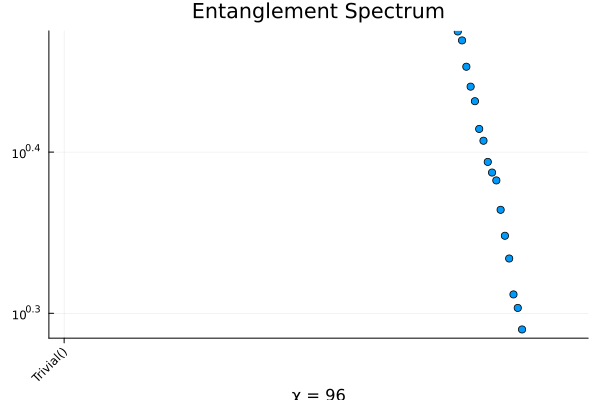

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

┌ Warning: dmrg failed to converge 0.00011698492926898899>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


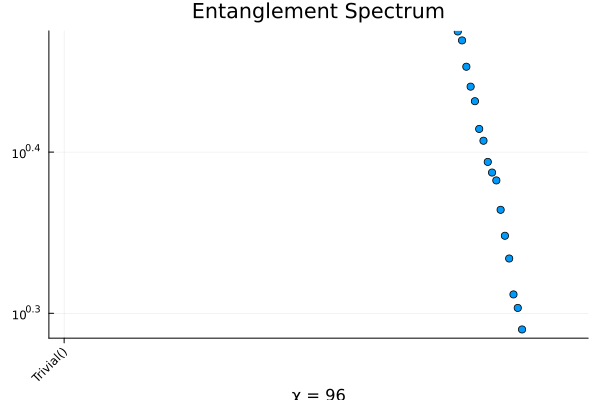

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

┌ Warning: dmrg failed to converge 0.00018185088074168767>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


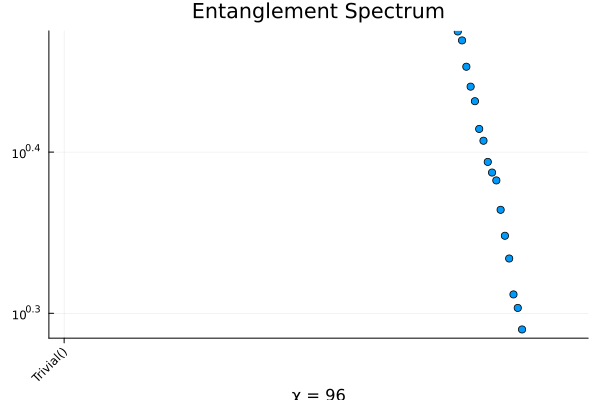

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

┌ Warning: dmrg failed to converge 0.0002839402577783535>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


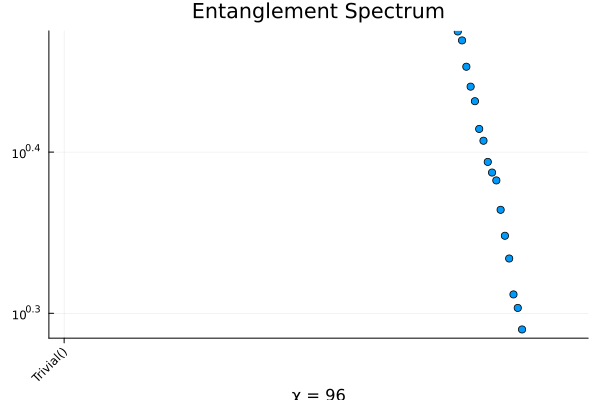

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

┌ Warning: dmrg failed to converge 0.00039269663616689623>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


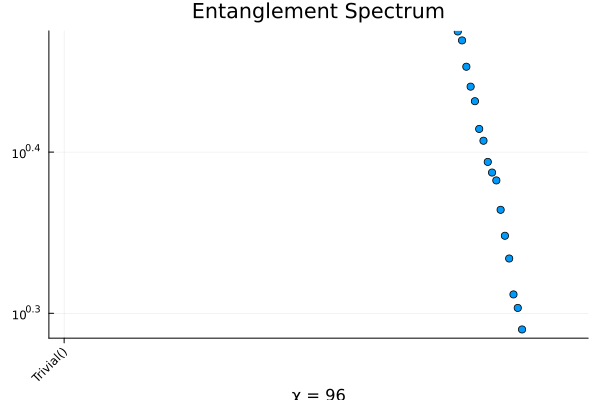

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

┌ Warning: dmrg failed to converge 0.000602591105449483>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


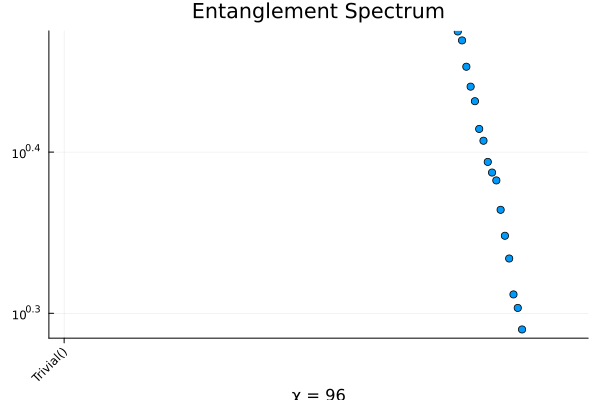

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

┌ Warning: dmrg failed to converge 0.0007199409869315902>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78



Error = |1- |< loop | mps >|^2 /(|< loop | loop >||< mps | mps >|)|  = 1.7606009715231963e-5
Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776

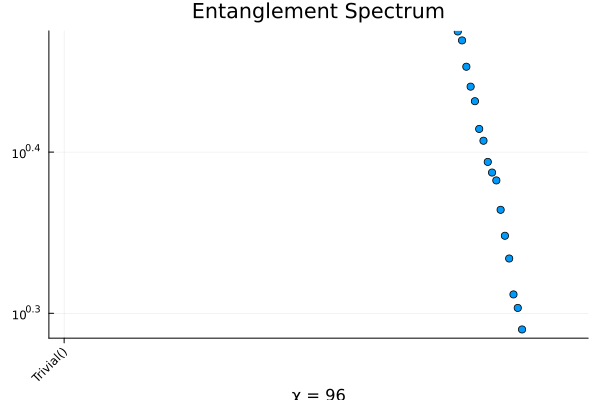

┌ Warning: dmrg failed to converge 0.0007074261705995989>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


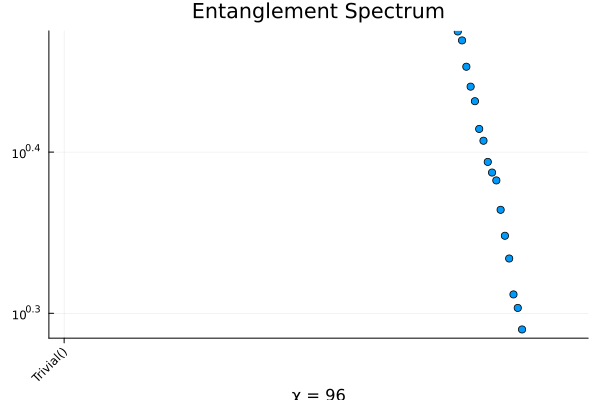

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

┌ Warning: dmrg failed to converge 0.00022512777430371797>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


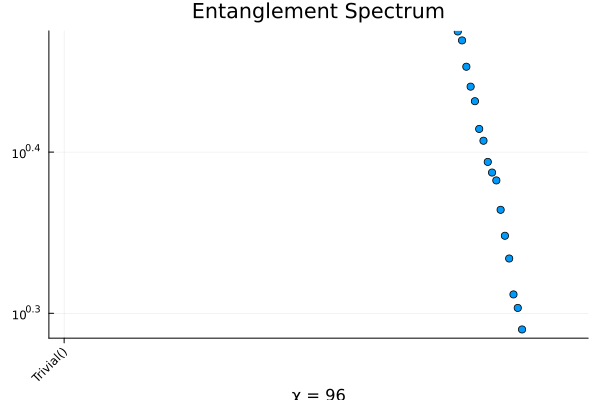

Any[:v1, :v2, :v3, :v4, :v5, :v6, :v7]
TensorKit.SortedVectorDict(Trivial() => [96.58549707649082, 9.312219349935253, 9.050074397835216, 8.945685113583874, 8.760376582522339, 8.651300001528544, 8.605541516676276, 8.45037498974355, 8.29999871386811, 8.169165202909195, 8.114619210941825, 8.085380328050672, 7.922789456569546, 7.806157906264836, 7.770495151227675, 7.628474837286579, 7.560978671420685, 7.481131133504866, 7.430202264432814, 7.415462853957639, 7.31689320207666, 7.27167700935664, 7.106853810932621, 7.0349462350411045, 6.911082881476702, 6.797153215890643, 6.7676510484627155, 6.68967400771107, 6.627305335497437, 6.537993445291359, 6.453049471049726, 6.34808182643968, 6.250117518234101, 6.202210187116212, 6.1300984870445285, 6.067028737627991, 5.984164390457111, 5.914003271104013, 5.845077452505325, 5.7313962504852505, 5.704886830223091, 5.649751270757898, 5.544653194324078, 5.502124776109069, 5.372407476633507, 5.310433286249208, 5.23858743749666, 5.107470507781483, 5.087148151

┌ Warning: dmrg failed to converge 0.0007419190843542978>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78



Error = |1- |< loop | mps >|^2 /(|< loop | loop >||< mps | mps >|)|  = 0.000350965054465302


In [5]:
error_list = []

chi_max_list = [97-i for i in 1:2:32]


for chi_max in chi_max_list
    mps_net_approx = compress_Tenet_MPS(mps_net_full, indices, chi_max, true)

    # d = Makie.plot(mps_net_approx, labels=true)
    # display(d)

    tens_tnet = vcat(Tenet.tensors(mps_net_full), Tenet.tensors(mps_net_approx))
    t_net_full = Tenet.TensorNetwork(tens_tnet)



    # d = Makie.plot(t_net_full)
    # display(d)



    contracted_loop = (Tenet.contract(mps_net_full))
    contracted_Qr = (Tenet.contract(mps_net_approx))
    """
    FIDELITY ANALYSIS
    """

    overlap_looploop = abs((Tenet.contract(contracted_loop, contracted_loop))[1])
    overlap_QrQr = abs((Tenet.contract(contracted_Qr, contracted_Qr))[1])
    overlap_full = abs((Tenet.contract(t_net_full))[1])
    println(" ---------------- Local fidelity analysis ----------------- ")
    # println("loop_loop = ", overlap_looploop)
    # println("mps_mps = ", overlap_QrQr)
    # println("mps loop = ", overlap_full)

    println("Error = |1- |< loop | mps >|^2 /(|< loop | loop >||< mps | mps >|)|  = ", abs(1- overlap_full^2/(overlap_looploop*overlap_QrQr)))
    push!(error_list, abs(1- overlap_full^2/(overlap_looploop*overlap_QrQr)))
end


┌ Warning: No strict ticks found
└ @ PlotUtils /home/bart/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/bart/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/bart/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils /home/bart/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/bart/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/bart/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils /home/bart/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/bart/.julia/packages/PlotUtils/jEGKP/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ Plo

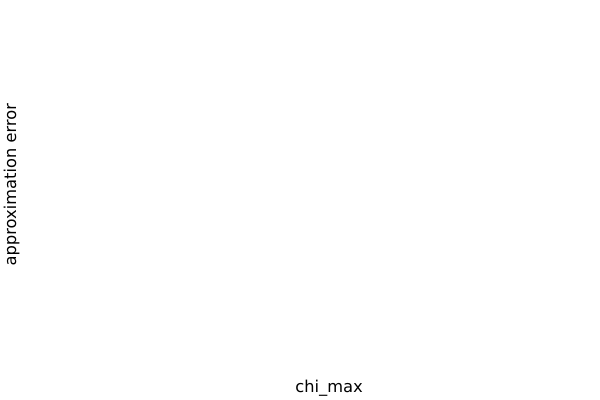

In [6]:
p = Plots.scatter(chi_max_list, error_list, xlabel ="chi_max", ylabel ="approximation error", yscale=:log10, legend=false)
display(p)